
# p04 Signal Lab: Theme ETF 任意シグナル評価フレーム

このNotebookは、テーマETF戦略の**任意銘柄選択シグナル**をプラグイン方式で評価する。

- ユーザが `SignalSpec` を追加して任意シグナルを登録
- t時点情報のみでt+1を評価（リーク防止）
- Exit taxonomy + anchors を共通計算
- 視覚的説明（採択→離脱）を重視した可視化パック
- Grid / Random 探索ランナー雛形を提供

比較基準:
- `DualMoM_W` 相当ベースライン
- `STMoM_WH` 相当ベースライン


In [1]:
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, Optional, Any, List, Tuple
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 240)
pd.set_option('display.width', 240)

NOTEBOOK_DIR = Path.cwd()
CANDIDATE_ROOTS = [NOTEBOOK_DIR, NOTEBOOK_DIR.parent]
PROJECT_ROOT = next((p for p in CANDIDATE_ROOTS if (p / 'data').exists() and (p / 'notebooks').exists()), NOTEBOOK_DIR)

DATA_PATH = PROJECT_ROOT / 'data' / 'us_sector_etf_9_ohlc.csv'
DEFAULT_COST_BPS = 10
DEFAULT_TOP_K = 3
DEFAULT_CORR_WINDOW = 12


In [2]:

# -------------------------
# Data & feature builders
# -------------------------
def rolling_zscore(df: pd.DataFrame, window: int = 12, min_periods: int = 12) -> pd.DataFrame:
    mu = df.rolling(window=window, min_periods=min_periods).mean()
    sd = df.rolling(window=window, min_periods=min_periods).std(ddof=1)
    return (df - mu) / sd


def cross_sectional_zscore(df: pd.DataFrame) -> pd.DataFrame:
    mu = df.mean(axis=1)
    sd = df.std(axis=1, ddof=1).replace(0, np.nan)
    return df.sub(mu, axis=0).div(sd, axis=0)


def build_base_features(adj_close_daily: pd.DataFrame, volume_daily: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict[str, pd.DataFrame]]:
    monthly_price = adj_close_daily.resample('ME').last()
    monthly_ret = monthly_price.pct_change()
    monthly_vol = volume_daily.resample('ME').sum(min_count=1)

    mom_12_2 = monthly_price.shift(2) / monthly_price.shift(12) - 1
    ret_1m = monthly_ret
    ret_3m = monthly_price.pct_change(3)
    ret_6m = monthly_price.pct_change(6)

    vol_3m = monthly_ret.rolling(3).std(ddof=1)
    vol_6m = monthly_ret.rolling(6).std(ddof=1)

    downside = monthly_ret.where(monthly_ret < 0, 0.0)
    downside_vol_6m = downside.rolling(6).std(ddof=1)

    turnover_z = rolling_zscore(np.log(monthly_vol.replace(0, np.nan)), window=12, min_periods=12)

    base_features = {
        'mom_12_2': mom_12_2,
        'ret_1m': ret_1m,
        'ret_3m': ret_3m,
        'ret_6m': ret_6m,
        'vol_3m': vol_3m,
        'vol_6m': vol_6m,
        'downside_vol_6m': downside_vol_6m,
        'turnover_z': turnover_z,
        'mom_12_2_cs_z': cross_sectional_zscore(mom_12_2),
        'turnover_cs_z': cross_sectional_zscore(turnover_z),
    }

    return monthly_price, monthly_ret, monthly_vol, base_features


df = pd.read_csv(str(DATA_PATH), header=[0, 1], index_col=0)
df.index = pd.to_datetime(df.index)

adj_close = df['Adj Close'].astype(float).ffill()
volume = df['Volume'].astype(float)

monthly_price, monthly_ret, monthly_vol, base_features = build_base_features(adj_close, volume)

print('daily rows:', len(df), 'monthly rows:', len(monthly_ret), 'n_assets:', monthly_ret.shape[1])
print('assets:', list(monthly_ret.columns))


daily rows: 3806 monthly rows: 182 n_assets: 9
assets: ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']


In [3]:

# -------------------------
# Public interfaces
# -------------------------
@dataclass
class SignalContext:
    monthly_price: pd.DataFrame
    monthly_ret: pd.DataFrame
    monthly_vol: pd.DataFrame
    base_features: Dict[str, pd.DataFrame]


@dataclass
class SignalSpec:
    name: str
    description: str
    params_schema: Dict[str, list | tuple]
    score_fn: Callable[[SignalContext, dict], pd.DataFrame]
    eligibility_fn: Optional[Callable[[SignalContext, dict], pd.DataFrame]] = None


@dataclass
class SelectionConfig:
    top_k: int = 3
    long_only: bool = True
    rebalance: str = 'monthly'
    cost_bps: float = 10.0


@dataclass
class BacktestResult:
    signal_name: str
    params: dict
    weights: pd.DataFrame
    ret_gross: pd.Series
    ret_net: pd.Series
    turnover: pd.Series
    exits: pd.DataFrame
    exit_reasons: pd.DataFrame
    anchors: pd.DataFrame
    summary: pd.DataFrame
    score_hold: pd.DataFrame
    eligibility_hold: pd.DataFrame
    selected_hold: pd.DataFrame
    rank_hold: pd.DataFrame
    rank_pct_hold: pd.DataFrame
    form_month_by_hold: pd.Series


@dataclass
class PanelConfig:
    tickers: Optional[list[str]] = None
    start: Optional[pd.Timestamp] = None
    end: Optional[pd.Timestamp] = None
    tickers_per_page: int = 3
    tie_method: str = 'min'
    normalize_price: bool = False


@dataclass
class EvaluationConfig:
    benchmark_names: List[str]
    objective_weights: Dict[str, float]
    corr_window: int = 12
    seed: int = 42


@dataclass
class EvaluationResult:
    metrics_table: pd.DataFrame
    objective_score: pd.Series
    visuals: Dict[str, Any]


SIGNAL_REGISTRY: Dict[str, SignalSpec] = {}


def register_signal(spec: SignalSpec) -> None:
    if spec.name in SIGNAL_REGISTRY:
        raise ValueError(f'duplicate signal name: {spec.name}')
    SIGNAL_REGISTRY[spec.name] = spec


def _validate_frame_shape(df: pd.DataFrame, context: SignalContext, frame_name: str, require_bool: bool = False) -> pd.DataFrame:
    if not isinstance(df, pd.DataFrame):
        raise TypeError(f'{frame_name} must be a pandas DataFrame')

    # index must be formation-month axis
    idx = pd.DatetimeIndex(df.index)
    if len(idx.intersection(context.monthly_ret.index)) == 0:
        raise ValueError(f'{frame_name} index must overlap monthly index')

    missing_cols = set(context.monthly_ret.columns) - set(df.columns)
    extra_cols = set(df.columns) - set(context.monthly_ret.columns)
    if missing_cols or extra_cols:
        raise ValueError(f'{frame_name} columns mismatch; missing={sorted(missing_cols)}, extra={sorted(extra_cols)}')

    out = df.copy().reindex(columns=context.monthly_ret.columns)
    if require_bool:
        out = out.fillna(False).astype(bool)
    else:
        out = out.astype(float)
        nan_ratio = float(out.isna().mean().mean())
        if nan_ratio >= 0.98:
            raise ValueError(f'{frame_name} NaN ratio too high: {nan_ratio:.3f}')
    return out


def build_signal_matrices(spec: SignalSpec, params: dict, context: SignalContext) -> Tuple[pd.DataFrame, pd.DataFrame]:
    score = spec.score_fn(context, params)
    score = _validate_frame_shape(score, context, f'{spec.name}.score_fn')

    if spec.eligibility_fn is None:
        elig = score.notna()
    else:
        elig = spec.eligibility_fn(context, params)
        elig = _validate_frame_shape(elig, context, f'{spec.name}.eligibility_fn', require_bool=True)

    # Common validity gate to enforce t->t+1 evaluability
    valid = score.notna() & context.monthly_ret.notna()
    elig = elig & valid
    return score, elig


context = SignalContext(
    monthly_price=monthly_price,
    monthly_ret=monthly_ret,
    monthly_vol=monthly_vol,
    base_features=base_features,
)

print('SignalContext ready:', context.monthly_ret.shape)


SignalContext ready: (182, 9)


In [4]:

# -------------------------
# Backtest core + exit/anchors
# -------------------------
def compute_in_port(W: pd.DataFrame, eps: float = 0.0) -> pd.DataFrame:
    return W.fillna(0.0) > eps


def compute_exit_events(W: pd.DataFrame) -> pd.DataFrame:
    in_port = compute_in_port(W)
    prev = in_port.shift(1).fillna(False)
    return prev & (~in_port)


def iqr(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) == 0:
        return np.nan
    return float(x.quantile(0.75) - x.quantile(0.25))


def spearman_corr(a: pd.Series, b: pd.Series) -> float:
    df = pd.concat([a, b], axis=1).dropna()
    if len(df) < 3:
        return np.nan

    ra = df.iloc[:, 0].rank()
    rb = df.iloc[:, 1].rank()
    if ra.nunique(dropna=True) < 2 or rb.nunique(dropna=True) < 2:
        return np.nan
    return float(ra.corr(rb))


def top_bottom_spread(score: pd.Series, fwd_ret: pd.Series, q: float = 0.3) -> float:
    df = pd.concat([score.rename('score'), fwd_ret.rename('ret')], axis=1).dropna()
    if len(df) < 6:
        return np.nan
    q_lo = df['score'].quantile(q)
    q_hi = df['score'].quantile(1 - q)
    top = df.loc[df['score'] >= q_hi, 'ret']
    bot = df.loc[df['score'] <= q_lo, 'ret']
    if len(top) == 0 or len(bot) == 0:
        return np.nan
    return float(top.mean() - bot.mean())


def avg_offdiag_corr(R: pd.DataFrame) -> float:
    if R.shape[1] < 2:
        return np.nan

    X = R.dropna(axis=0, how='any')
    if len(X) < 3:
        return np.nan

    # remove constant columns to avoid invalid correlation warnings
    std = X.std(axis=0, ddof=1)
    X = X.loc[:, std > 0]
    if X.shape[1] < 2:
        return np.nan

    C = X.corr()
    vals = C.values
    off = vals[~np.eye(vals.shape[0], dtype=bool)]
    off = off[np.isfinite(off)]
    if off.size == 0:
        return np.nan
    return float(off.mean())


def eig1_share(R: pd.DataFrame) -> float:
    if R.shape[1] < 2:
        return np.nan
    X = R.dropna(axis=0, how='any')
    if len(X) < 3:
        return np.nan
    cov = X.cov().values
    try:
        w = np.linalg.eigvalsh(cov)
    except np.linalg.LinAlgError:
        return np.nan
    s = float(np.nansum(w))
    if not np.isfinite(s) or s <= 0:
        return np.nan
    return float(np.nanmax(w) / s)


def annualized_metrics(ret: pd.Series, periods_per_year: int = 12) -> dict:
    ret = ret.dropna()
    if len(ret) == 0:
        return {'n_months': 0, 'CAGR': np.nan, 'Vol': np.nan, 'Sharpe': np.nan, 'MaxDD': np.nan, 'HitRate': np.nan}

    equity = (1 + ret).cumprod()
    years = len(ret) / periods_per_year
    cagr = equity.iloc[-1] ** (1 / years) - 1 if years > 0 else np.nan
    vol = ret.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe = (ret.mean() * periods_per_year) / vol if vol and vol > 0 else np.nan
    dd = equity / equity.cummax() - 1
    maxdd = dd.min()
    hit = (ret > 0).mean()

    return {
        'n_months': int(len(ret)),
        'CAGR': float(cagr),
        'Vol': float(vol),
        'Sharpe': float(sharpe),
        'MaxDD': float(maxdd),
        'HitRate': float(hit),
    }


def _select_assets(score_row: pd.Series, elig_row: pd.Series, top_k: int) -> List[str]:
    s = score_row.copy()
    e = elig_row.copy().astype(bool)
    s = s.where(e)
    s = s.dropna().sort_values(ascending=False)
    if len(s) == 0:
        return []
    return list(s.head(top_k).index)


def _build_exit_reasons_generic(
    W: pd.DataFrame,
    exit_df: pd.DataFrame,
    score_h: pd.DataFrame,
    elig_h: pd.DataFrame,
    selected_h: pd.DataFrame,
    hold_to_form: Dict[pd.Timestamp, pd.Timestamp],
) -> pd.DataFrame:
    reasons = pd.DataFrame('', index=W.index, columns=W.columns)
    for h in W.index:
        for a in W.columns:
            if not bool(exit_df.loc[h, a]):
                continue
            if h not in hold_to_form or h not in score_h.index:
                reasons.loc[h, a] = 'DATA_OUT'
            elif not bool(elig_h.loc[h, a]):
                reasons.loc[h, a] = 'ELIG_FAIL'
            elif not bool(selected_h.loc[h, a]):
                reasons.loc[h, a] = 'RANK_OUT'
            else:
                reasons.loc[h, a] = 'TIE_OR_CONSTRAINT'
    return reasons


def _compute_anchors(
    W: pd.DataFrame,
    monthly_ret: pd.DataFrame,
    hold_to_form: Dict[pd.Timestamp, pd.Timestamp],
    score_h: pd.DataFrame,
    selected_h: pd.DataFrame,
    corr_window: int = 12,
) -> pd.DataFrame:
    rows = []
    for h in W.index:
        if h not in hold_to_form:
            continue
        m = hold_to_form[h]
        if m not in monthly_ret.index:
            continue

        mi = monthly_ret.index.get_loc(m)
        lo = max(0, mi - corr_window + 1)
        win = monthly_ret.iloc[lo:mi + 1, :]

        sel_assets = list(selected_h.columns[selected_h.loc[h].fillna(False).values]) if h in selected_h.index else []
        R = win[sel_assets].dropna(axis=1, how='all') if len(sel_assets) > 0 else pd.DataFrame(index=win.index)

        crowd_corr = avg_offdiag_corr(R) if len(sel_assets) >= 2 else np.nan
        crowd_eig = eig1_share(R) if len(sel_assets) >= 2 else np.nan

        score = score_h.loc[h] if h in score_h.index else pd.Series(index=W.columns, dtype=float)
        fwd = monthly_ret.loc[h] if h in monthly_ret.index else pd.Series(index=W.columns, dtype=float)

        rank_ic = spearman_corr(score, fwd)
        spread = top_bottom_spread(score, fwd, q=0.3)
        disp = iqr(score)

        rows.append({
            'hold_month': h,
            'form_month': m,
            'n_sel': len(sel_assets),
            'crowd_avg_corr': crowd_corr,
            'crowd_eig1_share': crowd_eig,
            'rank_ic': rank_ic,
            'spread_top_bottom': spread,
            'dispersion_iqr': disp,
        })

    if not rows:
        return pd.DataFrame(columns=['form_month', 'n_sel', 'crowd_avg_corr', 'crowd_eig1_share', 'rank_ic', 'spread_top_bottom', 'dispersion_iqr'])

    return pd.DataFrame(rows).set_index('hold_month').sort_index()


def _make_summary(W: pd.DataFrame, exit_df: pd.DataFrame, ret_gross: pd.Series, turnover: pd.Series, ret_net: pd.Series) -> pd.DataFrame:
    in_port = compute_in_port(W)
    holdings_prev = in_port.shift(1).sum(axis=1).astype(float)
    exit_count = exit_df.sum(axis=1).astype(float)

    exit_rate = pd.Series(np.nan, index=W.index, dtype=float)
    mask = holdings_prev > 0
    exit_rate.loc[mask] = (exit_count.loc[mask] / holdings_prev.loc[mask]).astype(float)

    return pd.DataFrame({
        'holdings_prev': holdings_prev,
        'exit_count': exit_count,
        'exit_rate': exit_rate,
        'turnover': turnover.reindex(W.index),
        'ret_gross': ret_gross.reindex(W.index),
        'ret_net': ret_net.reindex(W.index),
    })


def build_rank_frames(score_hold: pd.DataFrame, eligibility_hold: pd.DataFrame, tie_method: str = 'min') -> tuple[pd.DataFrame, pd.DataFrame]:
    masked_score = score_hold.where(eligibility_hold)
    rank_hold = masked_score.rank(axis=1, ascending=False, method=tie_method, na_option='keep')

    n_eligible = eligibility_hold.sum(axis=1).replace(0, np.nan).astype(float)
    rank_pct_hold = rank_hold.rsub(n_eligible, axis=0).add(1.0).div(n_eligible, axis=0)

    rank_hold = rank_hold.where(eligibility_hold)
    rank_pct_hold = rank_pct_hold.where(eligibility_hold)
    return rank_hold, rank_pct_hold


def run_backtest(
    spec: SignalSpec,
    params: dict,
    context: SignalContext,
    selection_cfg: SelectionConfig,
    eval_cfg: EvaluationConfig,
) -> BacktestResult:
    if selection_cfg.rebalance != 'monthly':
        raise ValueError('Only monthly rebalance is supported')
    if not selection_cfg.long_only:
        raise ValueError('Current lab supports long_only=True only')

    score, elig = build_signal_matrices(spec, params, context)

    months = context.monthly_ret.index
    assets = list(context.monthly_ret.columns)

    w_list = []
    gross = []
    turn = []
    prev_w = pd.Series(0.0, index=assets)

    hold_to_form = {}
    score_by_hold = {}
    elig_by_hold = {}
    selected_by_hold = {}

    for i in range(len(months) - 1):
        m = months[i]
        h = months[i + 1]

        if m not in score.index:
            continue

        score_m = score.loc[m].copy()
        elig_m = elig.loc[m].copy()

        # strict time alignment: formation m -> hold h
        valid_h = context.monthly_ret.loc[h].notna()
        elig_m = elig_m & valid_h

        chosen = _select_assets(score_m, elig_m, selection_cfg.top_k)
        if len(chosen) == 0:
            continue

        w = pd.Series(0.0, index=assets)
        w.loc[chosen] = 1.0 / len(chosen)

        r_hold = context.monthly_ret.loc[h]
        g = float((w * r_hold).sum())
        t = float(0.5 * (w - prev_w).abs().sum())

        w_list.append(w.rename(h))
        gross.append((h, g))
        turn.append((h, t))

        sel = pd.Series(False, index=assets)
        sel.loc[chosen] = True

        hold_to_form[h] = m
        score_by_hold[h] = score_m
        elig_by_hold[h] = elig_m
        selected_by_hold[h] = sel

        prev_w = w

    if not w_list:
        raise ValueError(f'No valid portfolios generated for signal={spec.name}, params={params}')

    W = pd.DataFrame(w_list).sort_index()
    ret_gross = pd.Series(dict(gross), name=f'{spec.name}_gross').sort_index()
    turnover = pd.Series(dict(turn), name=f'{spec.name}_turnover').sort_index()
    ret_net = (ret_gross - turnover * (selection_cfg.cost_bps / 10000.0)).rename(f'{spec.name}_net')

    score_h = pd.DataFrame(score_by_hold).T.reindex(columns=assets)
    elig_h = pd.DataFrame(elig_by_hold).T.reindex(columns=assets)
    selected_h = pd.DataFrame(selected_by_hold).T.reindex(columns=assets)
    rank_h, rank_pct_h = build_rank_frames(score_h, elig_h, tie_method='min')
    form_month_by_hold = pd.Series(hold_to_form).sort_index().rename('form_month')

    exits = compute_exit_events(W)
    exit_reasons = _build_exit_reasons_generic(W, exits, score_h, elig_h, selected_h, hold_to_form)
    anchors = _compute_anchors(W, context.monthly_ret, hold_to_form, score_h, selected_h, corr_window=eval_cfg.corr_window)
    summary = _make_summary(W, exits, ret_gross, turnover, ret_net)

    return BacktestResult(
        signal_name=spec.name,
        params=params,
        weights=W,
        ret_gross=ret_gross,
        ret_net=ret_net,
        turnover=turnover,
        exits=exits,
        exit_reasons=exit_reasons,
        anchors=anchors,
        summary=summary,
        score_hold=score_h,
        eligibility_hold=elig_h,
        selected_hold=selected_h,
        rank_hold=rank_h,
        rank_pct_hold=rank_pct_h,
        form_month_by_hold=form_month_by_hold,
    )


In [5]:

# -------------------------
# Metrics & objective scoring
# -------------------------
def _robust_z(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    med = s.median()
    mad = (s - med).abs().median()
    if pd.isna(mad) or mad == 0:
        std = s.std(ddof=1)
        if pd.isna(std) or std == 0:
            return pd.Series(0.0, index=s.index)
        return (s - med) / std
    return (s - med) / (1.4826 * mad)


def safe_pearson_corr(a: pd.Series, b: pd.Series, min_n: int = 5) -> float:
    df = pd.concat([a, b], axis=1).dropna()
    if len(df) < min_n:
        return np.nan
    x = df.iloc[:, 0].astype(float)
    y = df.iloc[:, 1].astype(float)
    if x.nunique(dropna=True) < 2 or y.nunique(dropna=True) < 2:
        return np.nan
    return float(x.corr(y))


def _result_metrics(name: str, r: BacktestResult) -> Dict[str, float]:
    perf = annualized_metrics(r.ret_net)
    a = r.anchors
    s = r.summary

    rank_ic_mean = float(a['rank_ic'].mean()) if len(a) else np.nan
    rank_ic_std = float(a['rank_ic'].std(ddof=1)) if len(a) else np.nan
    spread_mean = float(a['spread_top_bottom'].mean()) if len(a) else np.nan
    turnover_mean = float(s['turnover'].mean()) if len(s) else np.nan
    exit_rate_vol = float(s['exit_rate'].std(ddof=1)) if len(s) else np.nan

    joined = s.join(a[['crowd_eig1_share', 'rank_ic']], how='left')
    corr_crowd_exit = safe_pearson_corr(joined['crowd_eig1_share'], joined['exit_rate'], min_n=5)
    corr_rankic_exit = safe_pearson_corr(joined['rank_ic'], joined['exit_rate'], min_n=5)

    q_hi = joined['crowd_eig1_share'].quantile(0.75)
    q_lo = joined['crowd_eig1_share'].quantile(0.25)
    hi = joined.loc[joined['crowd_eig1_share'] >= q_hi, 'exit_rate']
    lo = joined.loc[joined['crowd_eig1_share'] <= q_lo, 'exit_rate']
    crowd_bucket_gap = float(hi.mean() - lo.mean()) if len(hi) > 0 and len(lo) > 0 else np.nan

    explain_consistency = np.nanmean([
        crowd_bucket_gap,
        -corr_rankic_exit if pd.notna(corr_rankic_exit) else np.nan,
    ])

    return {
        'name': name,
        'n_months': perf['n_months'],
        'CAGR': perf['CAGR'],
        'Vol': perf['Vol'],
        'Sharpe': perf['Sharpe'],
        'MaxDD': perf['MaxDD'],
        'HitRate': perf['HitRate'],
        'rank_ic_mean': rank_ic_mean,
        'rank_ic_std': rank_ic_std,
        'spread_top_bottom_mean': spread_mean,
        'turnover_mean': turnover_mean,
        'exit_rate_vol': exit_rate_vol,
        'corr_crowd_exit_rate': corr_crowd_exit,
        'corr_rankic_exit_rate': corr_rankic_exit,
        'crowd_bucket_gap': crowd_bucket_gap,
        'explain_consistency': explain_consistency,
    }


def evaluate_results(results: Dict[str, BacktestResult], eval_cfg: EvaluationConfig) -> EvaluationResult:
    rows = [_result_metrics(name, r) for name, r in results.items()]
    mt = pd.DataFrame(rows).set_index('name').sort_index()

    # dimension sub-scores
    pred = pd.concat([
        _robust_z(mt['rank_ic_mean']),
        _robust_z(mt['spread_top_bottom_mean']),
    ], axis=1).mean(axis=1)

    oper = pd.concat([
        _robust_z(mt['Sharpe']),
        _robust_z(mt['CAGR']),
        _robust_z(-mt['MaxDD'].abs()),
        _robust_z(-mt['turnover_mean']),
    ], axis=1).mean(axis=1)

    stab = pd.concat([
        _robust_z(-mt['rank_ic_std']),
        _robust_z(-mt['exit_rate_vol']),
    ], axis=1).mean(axis=1)

    expl = _robust_z(mt['explain_consistency'])

    mt['score_predictive'] = pred
    mt['score_operational'] = oper
    mt['score_stability'] = stab
    mt['score_explainability'] = expl

    w = eval_cfg.objective_weights
    mt['objective_score'] = (
        w.get('predictive', 0.35) * mt['score_predictive']
        + w.get('operational', 0.35) * mt['score_operational']
        + w.get('stability', 0.20) * mt['score_stability']
        + w.get('explainability', 0.10) * mt['score_explainability']
    )

    bmarks = [b for b in eval_cfg.benchmark_names if b in mt.index]
    if len(bmarks) > 0:
        best_b = mt.loc[bmarks, 'objective_score'].max()
        mt['delta_vs_best_benchmark'] = mt['objective_score'] - best_b
    else:
        mt['delta_vs_best_benchmark'] = np.nan

    mt = mt.sort_values('objective_score', ascending=False)
    return EvaluationResult(metrics_table=mt, objective_score=mt['objective_score'], visuals={})


In [6]:

# -------------------------
# Visual explanation pack
# -------------------------
def _holding_durations_by_asset(W: pd.DataFrame) -> List[Tuple[str, int, int]]:
    in_port = compute_in_port(W)
    episodes = []
    idx = list(in_port.index)
    for a in in_port.columns:
        run = False
        s_idx = None
        for i, h in enumerate(idx):
            v = bool(in_port.loc[h, a])
            if v and not run:
                run = True
                s_idx = i
            if run and (not v):
                episodes.append((a, s_idx, i - 1))
                run = False
                s_idx = None
        if run and s_idx is not None:
            episodes.append((a, s_idx, len(idx) - 1))
    return episodes


def plot_holdings_matrix(result: BacktestResult, title: str):
    W0 = result.weights.fillna(0.0)
    fig, ax = plt.subplots(figsize=(12, 5))
    im = ax.imshow(W0.values, aspect='auto', interpolation='nearest')
    ax.set_title(title)
    ax.set_yticks(range(len(W0.index)))
    ax.set_yticklabels([d.strftime('%Y-%m') for d in W0.index], fontsize=8)
    ax.set_xticks(range(len(W0.columns)))
    ax.set_xticklabels(W0.columns, rotation=90, fontsize=8)

    marker_map = {
        'ELIG_FAIL': 'x',
        'RANK_OUT': 'o',
        'DATA_OUT': 's',
        'TIE_OR_CONSTRAINT': '*',
    }

    xs, ys, ms = [], [], []
    for yi, h in enumerate(W0.index):
        for xi, a in enumerate(W0.columns):
            if bool(result.exits.loc[h, a]):
                m = marker_map.get(result.exit_reasons.loc[h, a], '.')
                xs.append(xi)
                ys.append(yi)
                ms.append(m)

    for m in sorted(set(ms)):
        pts = [(x, y) for x, y, mm in zip(xs, ys, ms) if mm == m]
        if len(pts) == 0:
            continue
        px = [p[0] for p in pts]
        py = [p[1] for p in pts]
        ax.scatter(px, py, marker=m, s=28, linewidths=1)

    fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
    fig.tight_layout()
    plt.show()


def plot_reason_timeseries(result: BacktestResult, title: str):
    reason_df = result.exit_reasons
    summary_df = result.summary

    reasons = sorted([r for r in pd.unique(reason_df.values.ravel()) if isinstance(r, str) and r != ''])
    counts = {r: (reason_df == r).sum(axis=1) for r in reasons}

    idx = summary_df.index
    x = np.arange(len(idx))

    fig, ax = plt.subplots(figsize=(12, 4))
    bottom = np.zeros(len(idx))
    for r in reasons:
        y = counts[r].reindex(idx).fillna(0).values
        ax.bar(x, y, bottom=bottom, label=r)
        bottom += y

    ax2 = ax.twinx()
    ax2.plot(x, summary_df['turnover'].reindex(idx).values, linewidth=1.5)

    ax.set_title(title)
    ax.set_ylabel('Exit count')
    ax2.set_ylabel('Turnover (one-way)')
    ax.set_xticks(x)
    ax.set_xticklabels([d.strftime('%Y-%m') for d in idx], rotation=90, fontsize=8)
    ax.legend(loc='upper left', fontsize=8, ncol=2)
    fig.tight_layout()
    plt.show()


def plot_regime_map(result: BacktestResult, title: str):
    df = result.anchors.join(result.summary[['exit_rate']], how='left').dropna(subset=['dispersion_iqr', 'crowd_eig1_share'])
    if len(df) == 0:
        print('No regime-map data for', title)
        return

    x = df['dispersion_iqr'].values
    y = df['crowd_eig1_share'].values
    c = df['rank_ic'].values
    s = (df['exit_rate'].fillna(0).values * 800) + 20

    fig, ax = plt.subplots(figsize=(6, 5))
    sc = ax.scatter(x, y, c=c, s=s)
    ax.set_title(title)
    ax.set_xlabel('dispersion_iqr')
    ax.set_ylabel('crowd_eig1_share')
    fig.colorbar(sc, ax=ax, fraction=0.04, pad=0.02, label='rank_ic')
    fig.tight_layout()
    plt.show()


def plot_event_study(result: BacktestResult, cols: List[str], window: int, title: str, mode: str = 'high_crowd'):
    summary = result.summary
    anchors = result.anchors

    if mode == 'high_crowd':
        q = anchors['crowd_eig1_share'].quantile(0.75)
        event_months = anchors.index[anchors['crowd_eig1_share'] >= q]
    elif mode == 'low_rank_ic':
        q = anchors['rank_ic'].quantile(0.25)
        event_months = anchors.index[anchors['rank_ic'] <= q]
    else:
        raise ValueError('mode must be high_crowd or low_rank_ic')

    idx = summary.index
    pos = {d: i for i, d in enumerate(idx)}

    rows = []
    for h in event_months:
        if h not in pos:
            continue
        i0 = pos[h]
        lo = max(0, i0 - window)
        hi = min(len(idx) - 1, i0 + window)
        rel = np.arange(lo, hi + 1) - i0

        block = pd.DataFrame(index=rel)
        for col in cols:
            s = summary[col] if col in summary.columns else anchors[col]
            block[col] = s.reindex(idx[lo:hi + 1]).values
        rows.append(block)

    if len(rows) == 0:
        print('No event-study data for', title)
        return

    panel = pd.concat(rows, keys=range(len(rows)), names=['event', 'rel'])
    mean_path = panel.groupby(level='rel').mean(numeric_only=True)

    fig, axes = plt.subplots(len(cols), 1, figsize=(10, 2.3 * len(cols)), sharex=True)
    if len(cols) == 1:
        axes = [axes]

    for ax, col in zip(axes, cols):
        ax.plot(mean_path.index.values, mean_path[col].values)
        ax.axvline(0, linestyle='--', linewidth=1)
        ax.set_ylabel(col)
        ax.grid(alpha=0.3)

    axes[0].set_title(title)
    axes[-1].set_xlabel('months relative to event')
    fig.tight_layout()
    plt.show()


def plot_entry_to_exit_cohort(result: BacktestResult, context: SignalContext, anchor_col: str = 'crowd_eig1_share', title: str = ''):
    W = result.weights
    episodes = _holding_durations_by_asset(W)
    if len(episodes) == 0:
        print('No holding episodes')
        return

    rows = []
    idx = list(W.index)
    for asset, s, e in episodes:
        entry_h = idx[s]
        exit_h = idx[e]
        rr = context.monthly_ret.loc[idx[s:e + 1], asset].fillna(0.0)
        cum = (1 + rr).cumprod() - 1

        anchor_val = result.anchors[anchor_col].reindex([entry_h]).iloc[0] if anchor_col in result.anchors.columns else np.nan
        for t, v in enumerate(cum.values):
            rows.append({'asset': asset, 'entry_h': entry_h, 'exit_h': exit_h, 'rel_t': t, 'cumret': float(v), 'anchor': anchor_val})

    df = pd.DataFrame(rows)
    if df['anchor'].notna().sum() == 0:
        df['bucket'] = 'all'
    else:
        q1 = df['anchor'].quantile(0.33)
        q2 = df['anchor'].quantile(0.67)
        df['bucket'] = np.where(df['anchor'] <= q1, 'low_anchor', np.where(df['anchor'] >= q2, 'high_anchor', 'mid_anchor'))

    fig, ax = plt.subplots(figsize=(8, 4))
    for b, g in df.groupby('bucket'):
        s = g.groupby('rel_t')['cumret'].mean()
        ax.plot(s.index, s.values, label=b)
    ax.axhline(0.0, linewidth=1)
    ax.set_title(title or f'Entry-to-exit cohort by {anchor_col}')
    ax.set_xlabel('months since entry')
    ax.set_ylabel('avg cumulative return')
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.show()


def plot_exit_hazard_by_anchor_bucket(result: BacktestResult, anchor_col: str = 'crowd_eig1_share', title: str = ''):
    W = result.weights
    episodes = _holding_durations_by_asset(W)
    if len(episodes) == 0:
        print('No holding episodes')
        return

    idx = list(W.index)
    data = []
    for asset, s, e in episodes:
        entry_h = idx[s]
        dur = e - s + 1
        anchor_val = result.anchors[anchor_col].reindex([entry_h]).iloc[0] if anchor_col in result.anchors.columns else np.nan
        data.append({'asset': asset, 'duration': dur, 'anchor': anchor_val})

    epi = pd.DataFrame(data)
    if epi['anchor'].notna().sum() == 0:
        epi['bucket'] = 'all'
    else:
        q1 = epi['anchor'].quantile(0.33)
        q2 = epi['anchor'].quantile(0.67)
        epi['bucket'] = np.where(epi['anchor'] <= q1, 'low_anchor', np.where(epi['anchor'] >= q2, 'high_anchor', 'mid_anchor'))

    fig, ax = plt.subplots(figsize=(8, 4))
    for b, g in epi.groupby('bucket'):
        durs = g['duration'].values
        max_t = int(np.max(durs))
        t_grid = np.arange(1, max_t + 1)
        hazard = []
        for t in t_grid:
            survivors = np.sum(durs >= t)
            exits = np.sum(durs == t)
            hz = exits / survivors if survivors > 0 else np.nan
            hazard.append(hz)
        ax.plot(t_grid, hazard, marker='o', linewidth=1, label=b)

    ax.set_title(title or f'Exit hazard by {anchor_col} bucket')
    ax.set_xlabel('holding month')
    ax.set_ylabel('hazard (exit prob)')
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.show()



def build_asset_panel_frame(result: BacktestResult, context: SignalContext, panel_cfg: PanelConfig) -> pd.DataFrame:
    hold_months = result.weights.index
    if panel_cfg.start is not None:
        hold_months = hold_months[hold_months >= pd.Timestamp(panel_cfg.start)]
    if panel_cfg.end is not None:
        hold_months = hold_months[hold_months <= pd.Timestamp(panel_cfg.end)]

    if panel_cfg.tickers is None:
        tickers = [t for t in result.weights.columns]
    else:
        tickers = [t for t in panel_cfg.tickers if t in result.weights.columns]

    if len(hold_months) == 0 or len(tickers) == 0:
        return pd.DataFrame(columns=['hold_month', 'ticker', 'price', 'signal', 'selected', 'rank', 'rank_pct', 'form_month'])

    panel_index = pd.MultiIndex.from_product([hold_months, tickers], names=['hold_month', 'ticker'])

    price = context.monthly_price.reindex(index=hold_months, columns=tickers).copy()
    if panel_cfg.normalize_price:
        for col in price.columns:
            s = price[col]
            valid = s.dropna()
            if len(valid) > 0 and float(valid.iloc[0]) != 0.0:
                price[col] = s / float(valid.iloc[0])

    signal = result.score_hold.reindex(index=hold_months, columns=tickers)
    selected = result.selected_hold.reindex(index=hold_months, columns=tickers).fillna(False).astype(int)
    rank = result.rank_hold.reindex(index=hold_months, columns=tickers)
    rank_pct = result.rank_pct_hold.reindex(index=hold_months, columns=tickers)

    panel = pd.DataFrame(index=panel_index)
    panel['price'] = price.to_numpy().reshape(-1)
    panel['signal'] = signal.to_numpy().reshape(-1)
    panel['selected'] = selected.to_numpy().reshape(-1)
    panel['rank'] = rank.to_numpy().reshape(-1)
    panel['rank_pct'] = rank_pct.to_numpy().reshape(-1)

    form_month_map = result.form_month_by_hold.reindex(hold_months)
    panel['form_month'] = panel.index.get_level_values('hold_month').map(form_month_map.to_dict())

    return panel.reset_index()


def plot_asset_quad_pages(panel_df: pd.DataFrame, panel_cfg: PanelConfig, title_prefix: str) -> list:
    if len(panel_df) == 0:
        print('No panel data')
        return []

    tickers = list(dict.fromkeys(panel_df['ticker'].tolist()))
    per_page = max(1, int(panel_cfg.tickers_per_page))
    figures = []

    n_pages = (len(tickers) + per_page - 1) // per_page
    for page in range(n_pages):
        chunk = tickers[page * per_page:(page + 1) * per_page]
        n_cols = len(chunk)

        fig, axes = plt.subplots(4, n_cols, figsize=(4.8 * n_cols, 10), sharex='col')
        if n_cols == 1:
            axes = np.array(axes).reshape(4, 1)

        for j, ticker in enumerate(chunk):
            sub = panel_df.loc[panel_df['ticker'] == ticker].sort_values('hold_month')
            x = sub['hold_month']

            ax_price = axes[0, j]
            ax_signal = axes[1, j]
            ax_selected = axes[2, j]
            ax_rank = axes[3, j]

            ax_price.plot(x, sub['price'], color='tab:blue', linewidth=1.2, label='price')
            ax_price.set_title(str(ticker), fontsize=10)
            ax_price.legend(loc='upper left', fontsize=7, frameon=False)

            ax_signal.plot(x, sub['signal'], color='tab:orange', linewidth=1.2)
            ax_signal.axhline(0.0, color='gray', linewidth=0.8, linestyle='--')

            ax_selected.step(x, sub['selected'].fillna(0).astype(float), where='mid', color='tab:green', linewidth=1.2)
            ax_selected.set_ylim(-0.1, 1.1)

            ax_rank.plot(x, sub['rank'], color='tab:red', linewidth=1.2, marker='o', markersize=2)
            valid_rank = sub['rank'].dropna()
            if len(valid_rank) > 0:
                max_rank = max(1.0, float(valid_rank.max()))
                ax_rank.set_ylim(max_rank + 0.5, 0.5)

            if j == 0:
                ax_price.set_ylabel('Price')
                ax_signal.set_ylabel('Signal')
                ax_selected.set_ylabel('Selected(0/1)')
                ax_rank.set_ylabel('Rank')

            for ax in [ax_price, ax_signal, ax_selected, ax_rank]:
                ax.grid(alpha=0.25)

            for label in ax_rank.get_xticklabels():
                label.set_rotation(45)
                label.set_horizontalalignment('right')

        fig.suptitle(f'{title_prefix} | page {page + 1}/{n_pages}', y=1.01, fontsize=12)
        fig.tight_layout()
        plt.show()
        figures.append(fig)

    return figures


def run_signal_panel(
    signal_name: str,
    params: dict,
    context: SignalContext,
    selection_cfg: SelectionConfig,
    eval_cfg: EvaluationConfig,
    panel_cfg: PanelConfig,
) -> tuple[BacktestResult, pd.DataFrame, list]:
    if signal_name not in SIGNAL_REGISTRY:
        raise ValueError(f'Unknown signal_name: {signal_name}')

    spec = SIGNAL_REGISTRY[signal_name]
    result = run_backtest(spec, params, context, selection_cfg, eval_cfg)
    panel_df = build_asset_panel_frame(result, context, panel_cfg)

    param_desc = ', '.join([f'{k}={params[k]}' for k in sorted(params.keys())])
    title_prefix = f'{signal_name} ({param_desc})' if param_desc else signal_name
    figures = plot_asset_quad_pages(panel_df, panel_cfg, title_prefix)
    return result, panel_df, figures


In [7]:

# -------------------------
# Signal plugins (benchmarks + user example)
# -------------------------
def dual_baseline_score(context: SignalContext, params: dict) -> pd.DataFrame:
    return context.base_features['mom_12_2']


def dual_baseline_elig(context: SignalContext, params: dict) -> pd.DataFrame:
    th = float(params.get('mom_threshold', 0.0))
    return context.base_features['mom_12_2'] > th


def st_wh_baseline_score(context: SignalContext, params: dict) -> pd.DataFrame:
    ret = context.base_features['ret_1m']
    turn = context.base_features['turnover_z']
    w_ret = float(params.get('w_ret', 1.0))
    w_turn = float(params.get('w_turn', 0.25))
    return w_ret * cross_sectional_zscore(ret) + w_turn * cross_sectional_zscore(turn)


def st_wh_baseline_elig(context: SignalContext, params: dict) -> pd.DataFrame:
    ret = context.base_features['ret_1m']
    turn = context.base_features['turnover_z']
    r_med = ret.median(axis=1)
    t_med = turn.median(axis=1)
    return ret.ge(r_med, axis=0) & turn.ge(t_med, axis=0)


def user_mom_turn_blend_score(context: SignalContext, params: dict) -> pd.DataFrame:
    alpha = float(params.get('alpha', 0.7))
    beta = float(params.get('beta', 0.3))
    mom = context.base_features['mom_12_2_cs_z']
    turn = context.base_features['turnover_cs_z']
    vol = cross_sectional_zscore(context.base_features['vol_3m'])

    # example: momentum + turnover - short-term volatility penalty
    gamma = float(params.get('gamma', 0.15))
    return alpha * mom + beta * turn - gamma * vol


def user_mom_turn_blend_elig(context: SignalContext, params: dict) -> pd.DataFrame:
    th = float(params.get('mom_threshold', 0.0))
    return context.base_features['mom_12_2'] > th


# user template: copy this and modify
# def my_signal_score(context: SignalContext, params: dict) -> pd.DataFrame:
#     return context.base_features['mom_12_2']
#
# def my_signal_elig(context: SignalContext, params: dict) -> pd.DataFrame:
#     return context.base_features['mom_12_2'] > 0


register_signal(SignalSpec(
    name='dual_baseline',
    description='Dual Momentum baseline proxy',
    params_schema={'mom_threshold': [0.0]},
    score_fn=dual_baseline_score,
    eligibility_fn=dual_baseline_elig,
))

register_signal(SignalSpec(
    name='st_wh_baseline',
    description='STMoM winner/high-turnover baseline proxy',
    params_schema={'w_ret': [1.0], 'w_turn': [0.25]},
    score_fn=st_wh_baseline_score,
    eligibility_fn=st_wh_baseline_elig,
))

register_signal(SignalSpec(
    name='user_mom_turn_blend',
    description='User-definable blend (momentum + turnover - vol)',
    params_schema={
        'alpha': (0.2, 1.0),
        'beta': (0.0, 1.0),
        'gamma': (0.0, 0.5),
        'mom_threshold': (-0.1, 0.2),
    },
    score_fn=user_mom_turn_blend_score,
    eligibility_fn=user_mom_turn_blend_elig,
))

print('registered signals:', list(SIGNAL_REGISTRY.keys()))


registered signals: ['dual_baseline', 'st_wh_baseline', 'user_mom_turn_blend']


In [8]:

# -------------------------
# Baseline + user signal evaluation
# -------------------------
selection_cfg = SelectionConfig(
    top_k=DEFAULT_TOP_K,
    long_only=True,
    rebalance='monthly',
    cost_bps=DEFAULT_COST_BPS,
)


eval_cfg = EvaluationConfig(
    benchmark_names=['dual_baseline', 'st_wh_baseline'],
    objective_weights={'predictive': 0.35, 'operational': 0.35, 'stability': 0.20, 'explainability': 0.10},
    corr_window=DEFAULT_CORR_WINDOW,
    seed=42,
)


run_specs = [
    ('dual_baseline', {'mom_threshold': 0.0}),
    ('st_wh_baseline', {'w_ret': 1.0, 'w_turn': 0.25}),
    ('user_mom_turn_blend', {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.15, 'mom_threshold': 0.0}),
]

results = {}
for name, params in run_specs:
    spec = SIGNAL_REGISTRY[name]
    results[name] = run_backtest(spec, params, context, selection_cfg, eval_cfg)


ev = evaluate_results(results, eval_cfg)

display(ev.metrics_table)

print('Exit reason counts by signal:')
for name, r in results.items():
    cnt = r.exit_reasons.replace('', np.nan).stack().value_counts()
    print('\n', name)
    display(cnt.rename('count'))


n_months      CAGR       Vol    Sharpe     MaxDD   HitRate  rank_ic_mean  rank_ic_std  spread_top_bottom_mean  turnover_mean  exit_rate_vol  corr_crowd_exit_rate  corr_rankic_exit_rate  crowd_bucket_gap  \
name                                                                                                                                                                                                                              
dual_baseline             169  0.131209  0.139313  0.959174 -0.196503  0.656805     -0.010651     0.445786                0.000050       0.230769       0.211413             -0.155131              -0.061445         -0.071429   
user_mom_turn_blend       169  0.141896  0.138894  1.029681 -0.171640  0.662722     -0.022189     0.417581               -0.000496       0.278107       0.231786             -0.089522               0.053424         -0.023810   
st_wh_baseline            170  0.110204  0.146425  0.790158 -0.287043  0.605882     -0.013725     0.404041               -0.000368       0.698039       0.305340             -0.039787               0.027631          0.025000   

                     explain_consistency  score_predictive  score_operational  score_stability  score_explainability  objective_score  delta_vs_best_benchmark  
name                                                                                                                                                            
dual_baseline                  -0.004992          1.438534           0.168623        -0.365242              0.000000         0.489456                 0.000000  
user_mom_turn_blend            -0.038617         -1.265625           0.505868         0.000000             -6.168985        -0.882813                -1.372270  
st_wh_baseline                 -0.001315          0.000000          -2.845566        -0.880291              0.674491        -1.104557                -1.594014

Exit reason counts by signal:

 dual_baseline


RANK_OUT     93
ELIG_FAIL    15
Name: count, dtype: int64


 st_wh_baseline


ELIG_FAIL    267
RANK_OUT       6
Name: count, dtype: int64


 user_mom_turn_blend


RANK_OUT     113
ELIG_FAIL     19
Name: count, dtype: int64

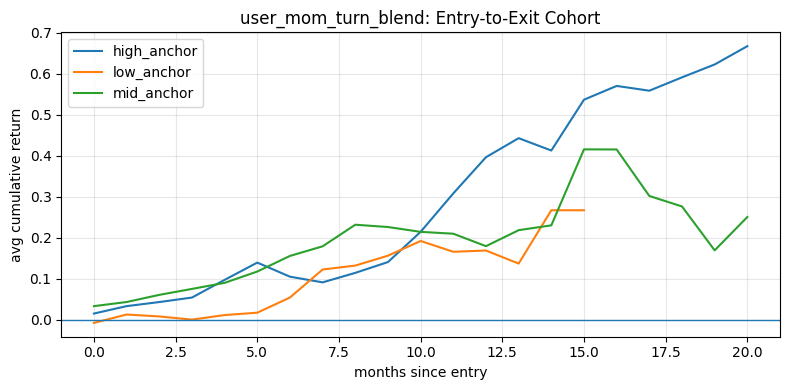

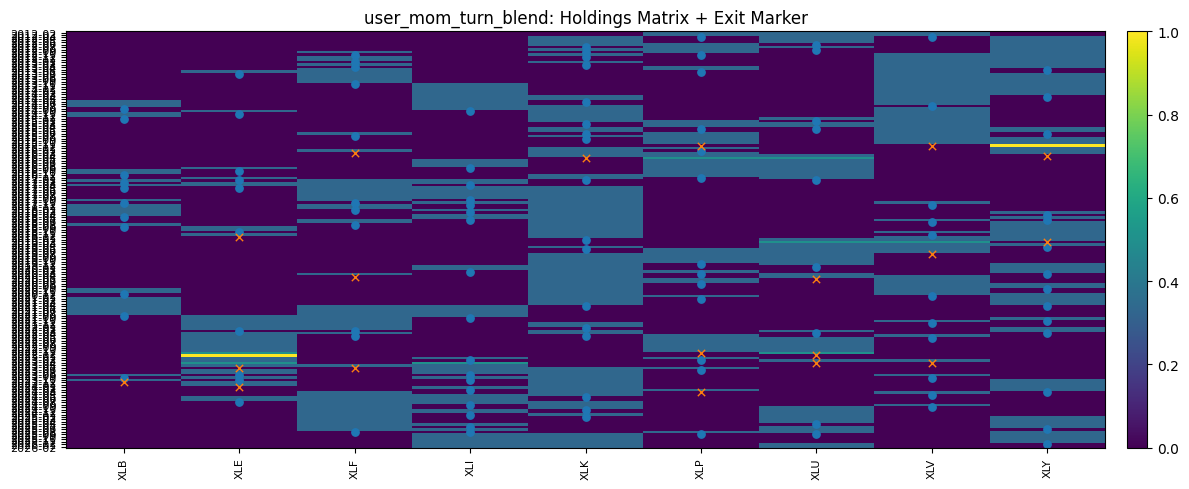

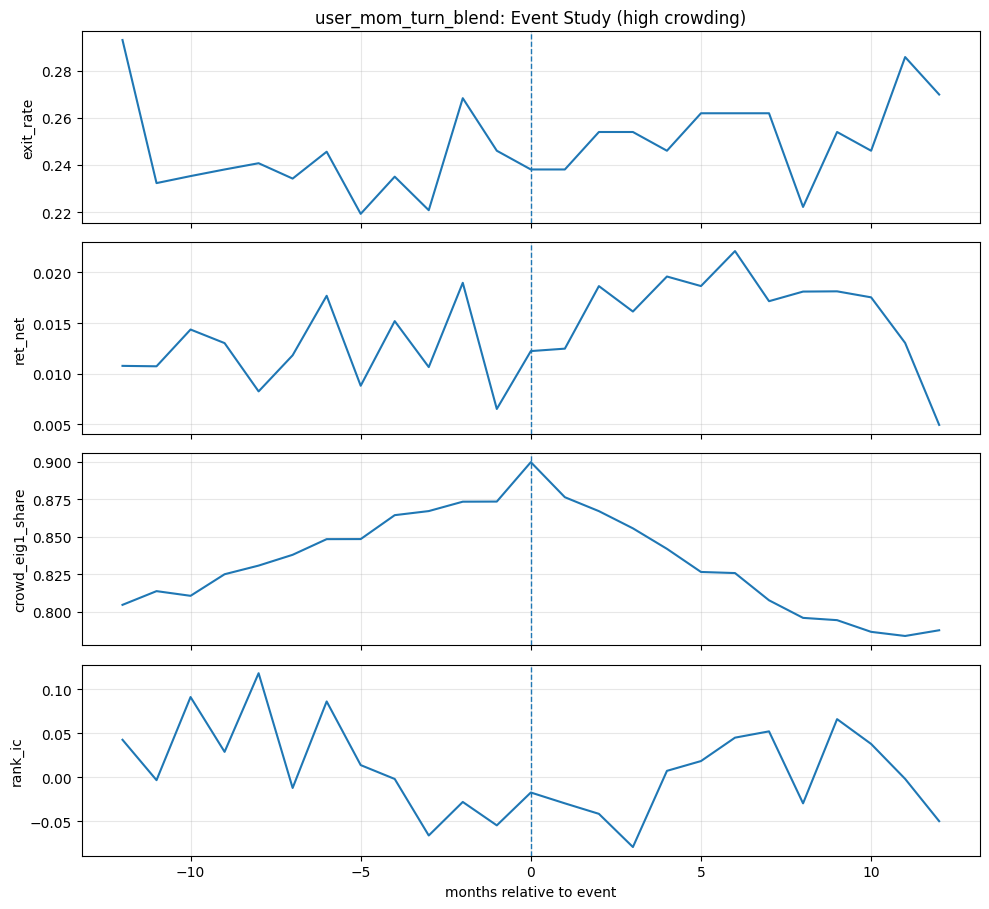

In [9]:

# -------------------------
# Visual explanation demo (user signal)
# -------------------------
target_name = 'user_mom_turn_blend'
r = results[target_name]

plot_entry_to_exit_cohort(r, context, anchor_col='crowd_eig1_share', title=f'{target_name}: Entry-to-Exit Cohort')
plot_exit_hazard_by_anchor_bucket(r, anchor_col='crowd_eig1_share', title=f'{target_name}: Exit Hazard by Anchor Bucket')
plot_holdings_matrix(r, title=f'{target_name}: Holdings Matrix + Exit Marker')
plot_reason_timeseries(r, title=f'{target_name}: Exit Reasons + Turnover')
plot_regime_map(r, title=f'{target_name}: Regime Map')
plot_event_study(r, cols=['exit_rate', 'ret_net', 'crowd_eig1_share', 'rank_ic'], window=12, title=f'{target_name}: Event Study (high crowding)', mode='high_crowd')


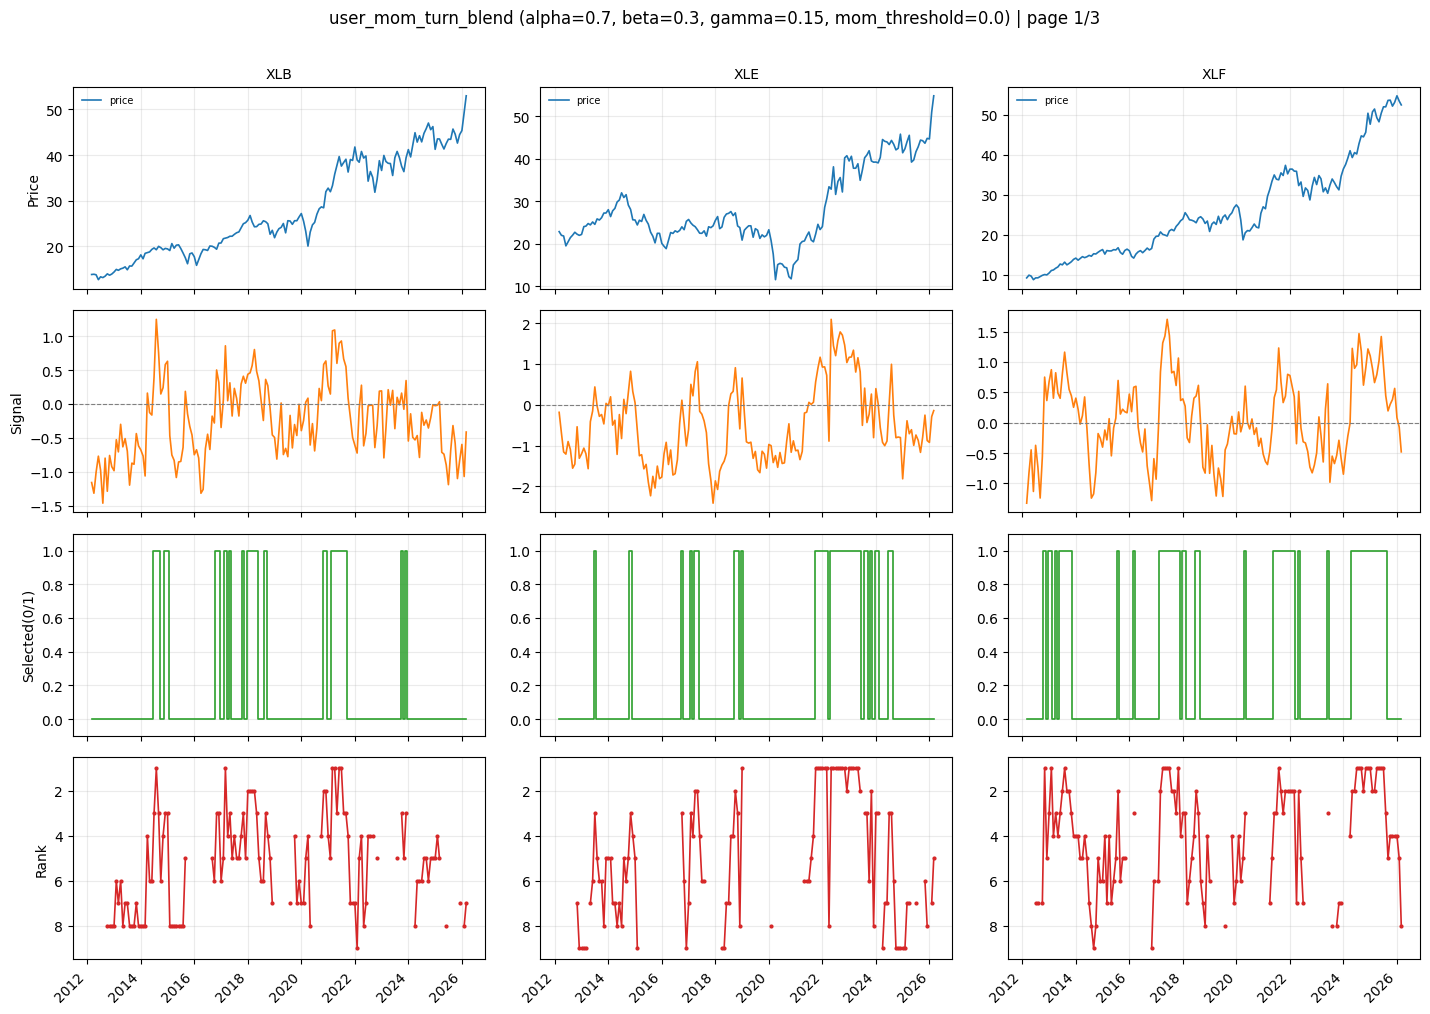

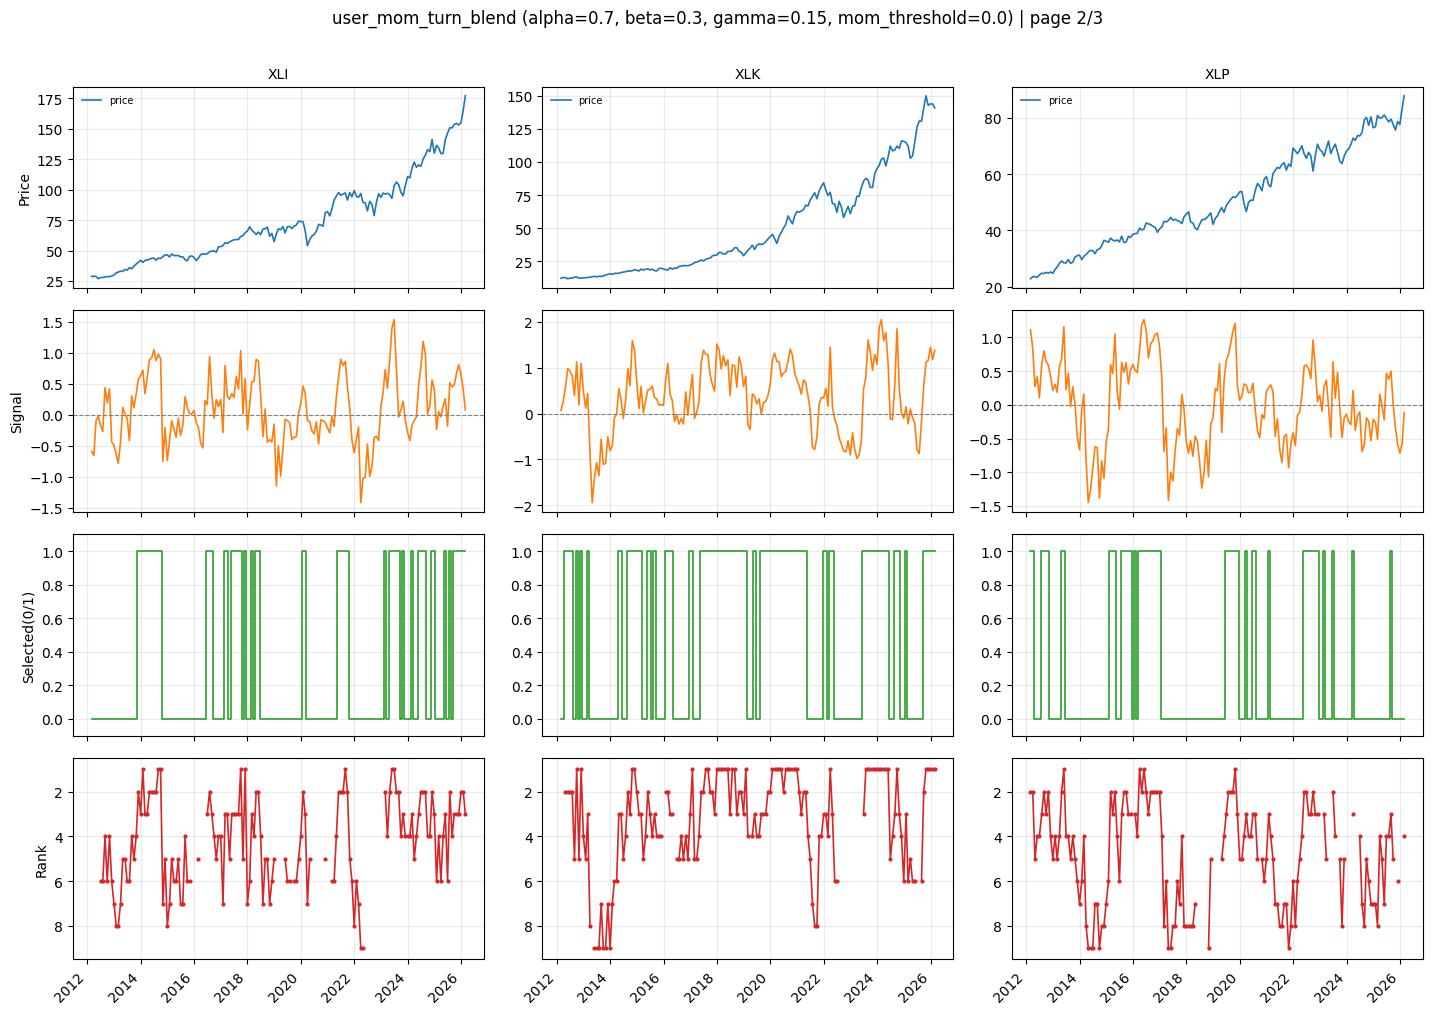

panel signal: user_mom_turn_blend
panel rows: 1521 unique tickers: 9 pages: 3


hold_month ticker      price    signal  selected  rank  rank_pct form_month
0  2012-02-29    XLB  13.871223 -1.156771         0   NaN       NaN 2012-01-31
1  2012-02-29    XLE  22.855959 -0.186044         0   NaN       NaN 2012-01-31
2  2012-02-29    XLF   9.275579 -1.326000         0   NaN       NaN 2012-01-31
3  2012-02-29    XLI  28.711210 -0.593229         0   NaN       NaN 2012-01-31
4  2012-02-29    XLK  12.031635  0.065836         0   NaN       NaN 2012-01-31
5  2012-02-29    XLP  22.859064  1.115143         1   2.0      0.75 2012-01-31
6  2012-02-29    XLU  10.911338  1.429091         1   1.0      1.00 2012-01-31
7  2012-02-29    XLV  28.664936  0.627354         1   3.0      0.50 2012-01-31
8  2012-02-29    XLY  18.302015  0.024621         0   4.0      0.25 2012-01-31
9  2012-03-31    XLB  13.924046 -1.314668         0   NaN       NaN 2012-02-29
10 2012-03-31    XLE  21.985168 -0.692452         0   NaN       NaN 2012-02-29
11 2012-03-31    XLF   9.960845 -0.830823         0   NaN       NaN 2012-02-29

In [10]:

# -------------------------
# Arbitrary signal panel demo (price/signal/selected/rank)
# -------------------------
panel_signal_name = 'user_mom_turn_blend'
panel_params = {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.15, 'mom_threshold': 0.0}

panel_cfg = PanelConfig(
    tickers=None,
    start=None,
    end=None,
    tickers_per_page=3,
    tie_method='min',
    normalize_price=False,
)

panel_result, panel_df, panel_figs = run_signal_panel(
    signal_name=panel_signal_name,
    params=panel_params,
    context=context,
    selection_cfg=selection_cfg,
    eval_cfg=eval_cfg,
    panel_cfg=panel_cfg,
)

print('panel signal:', panel_signal_name)
print('panel rows:', len(panel_df), 'unique tickers:', panel_df['ticker'].nunique(), 'pages:', len(panel_figs))
display(panel_df.head(12))


In [11]:

# -------------------------
# Search runners (Grid -> Random)
# -------------------------
def _normalize_param_value(v):
    if isinstance(v, float):
        return round(v, 6)
    return v


def _param_key(params: dict) -> str:
    keys = sorted(params.keys())
    return ', '.join([f'{k}={_normalize_param_value(params[k])}' for k in keys])


def _sample_param(space, rng: np.random.Generator):
    if isinstance(space, list):
        return space[int(rng.integers(0, len(space)))]
    if isinstance(space, tuple):
        if len(space) == 2 and all(isinstance(x, (int, float)) for x in space):
            lo, hi = space
            return float(rng.uniform(lo, hi))
        if len(space) == 3 and isinstance(space[2], str) and space[2] == 'int':
            lo, hi, _ = space
            return int(rng.integers(int(lo), int(hi) + 1))
    raise ValueError(f'Unsupported param space: {space}')


def run_grid_search(
    signal_spec: SignalSpec,
    param_grid: Dict[str, list],
    context: SignalContext,
    selection_cfg: SelectionConfig,
    eval_cfg: EvaluationConfig,
    benchmark_results: Dict[str, BacktestResult],
):
    keys = list(param_grid.keys())
    combos = list(product(*[param_grid[k] for k in keys]))

    candidate_results = {}
    candidate_params = {}

    for i, combo in enumerate(combos):
        params = dict(zip(keys, combo))
        run_name = f'{signal_spec.name}[{i}]'
        try:
            res = run_backtest(signal_spec, params, context, selection_cfg, eval_cfg)
            candidate_results[run_name] = res
            candidate_params[run_name] = params
        except Exception as e:
            print('grid skip:', run_name, 'reason:', e)

    all_results = {}
    all_results.update(benchmark_results)
    all_results.update(candidate_results)

    ev = evaluate_results(all_results, eval_cfg)
    lb = ev.metrics_table.loc[list(candidate_results.keys())].copy() if len(candidate_results) > 0 else pd.DataFrame()

    if len(lb) > 0:
        for k in keys:
            lb[k] = [candidate_params[n][k] for n in lb.index]
        lb = lb.sort_values('objective_score', ascending=False)

    return lb, ev, candidate_results


def run_random_search(
    signal_spec: SignalSpec,
    param_space: Dict[str, Any],
    n_trials: int,
    context: SignalContext,
    selection_cfg: SelectionConfig,
    eval_cfg: EvaluationConfig,
    benchmark_results: Dict[str, BacktestResult],
):
    rng = np.random.default_rng(eval_cfg.seed)

    candidate_results = {}
    candidate_params = {}

    for i in range(n_trials):
        params = {k: _sample_param(space, rng) for k, space in param_space.items()}
        run_name = f'{signal_spec.name}[rand_{i}]'
        try:
            res = run_backtest(signal_spec, params, context, selection_cfg, eval_cfg)
            candidate_results[run_name] = res
            candidate_params[run_name] = params
        except Exception as e:
            print('random skip:', run_name, 'reason:', e)

    all_results = {}
    all_results.update(benchmark_results)
    all_results.update(candidate_results)

    ev = evaluate_results(all_results, eval_cfg)
    lb = ev.metrics_table.loc[list(candidate_results.keys())].copy() if len(candidate_results) > 0 else pd.DataFrame()

    if len(lb) > 0:
        for k in param_space.keys():
            lb[k] = [candidate_params[n][k] for n in lb.index]
        lb = lb.sort_values('objective_score', ascending=False)

    return lb, ev, candidate_results


def plot_grid_heatmap(leaderboard: pd.DataFrame, x_param: str, y_param: str, value_col: str = 'objective_score', title: str = ''):
    if len(leaderboard) == 0:
        print('No leaderboard data')
        return
    if x_param not in leaderboard.columns or y_param not in leaderboard.columns:
        print('params not in leaderboard')
        return

    pv = leaderboard.pivot_table(index=y_param, columns=x_param, values=value_col, aggfunc='mean')
    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(pv.values, aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pv.columns)))
    ax.set_xticklabels([str(v) for v in pv.columns], rotation=45, ha='right')
    ax.set_yticks(range(len(pv.index)))
    ax.set_yticklabels([str(v) for v in pv.index])
    ax.set_title(title or f'{value_col} heatmap')
    ax.set_xlabel(x_param)
    ax.set_ylabel(y_param)
    fig.colorbar(im, ax=ax, fraction=0.04, pad=0.02)
    fig.tight_layout()
    plt.show()


def plot_param_sensitivity(leaderboard: pd.DataFrame, param_cols: List[str], value_col: str = 'objective_score'):
    if len(leaderboard) == 0:
        print('No leaderboard data')
        return

    n = len(param_cols)
    fig, axes = plt.subplots(n, 1, figsize=(8, 2.4 * n), sharey=False)
    if n == 1:
        axes = [axes]

    for ax, p in zip(axes, param_cols):
        g = leaderboard.groupby(p)[value_col].mean().sort_index()
        ax.plot(g.index, g.values, marker='o')
        ax.set_title(f'{p} vs {value_col}')
        ax.grid(alpha=0.3)
    fig.tight_layout()
    plt.show()


In [12]:

# -------------------------
# Search runner demo
# -------------------------
benchmark_results = {
    'dual_baseline': results['dual_baseline'],
    'st_wh_baseline': results['st_wh_baseline'],
}

signal_spec = SIGNAL_REGISTRY['user_mom_turn_blend']

param_grid = {
    'alpha': [0.4, 0.6, 0.8],
    'beta': [0.1, 0.3, 0.5],
    'gamma': [0.0, 0.15, 0.3],
    'mom_threshold': [0.0],
}

grid_lb, grid_ev, grid_results = run_grid_search(
    signal_spec=signal_spec,
    param_grid=param_grid,
    context=context,
    selection_cfg=selection_cfg,
    eval_cfg=eval_cfg,
    benchmark_results=benchmark_results,
)

print('Grid leaderboard (top 10):')
display(grid_lb.head(10))

plot_grid_heatmap(grid_lb, x_param='alpha', y_param='beta', value_col='objective_score', title='Grid sensitivity: alpha x beta')
plot_param_sensitivity(grid_lb, param_cols=['alpha', 'beta', 'gamma'], value_col='objective_score')

param_space = {
    'alpha': (0.2, 1.0),
    'beta': (0.0, 1.0),
    'gamma': (0.0, 0.5),
    'mom_threshold': (-0.1, 0.2),
}

rand_lb, rand_ev, rand_results = run_random_search(
    signal_spec=signal_spec,
    param_space=param_space,
    n_trials=20,
    context=context,
    selection_cfg=selection_cfg,
    eval_cfg=eval_cfg,
    benchmark_results=benchmark_results,
)

print('Random leaderboard (top 10):')
display(rand_lb.head(10))


Grid leaderboard (top 10):


n_months      CAGR       Vol    Sharpe     MaxDD   HitRate  rank_ic_mean  rank_ic_std  spread_top_bottom_mean  turnover_mean  exit_rate_vol  corr_crowd_exit_rate  corr_rankic_exit_rate  crowd_bucket_gap  \
name                                                                                                                                                                                                                                  
user_mom_turn_blend[12]       169  0.143508  0.136190  1.057888 -0.171640  0.668639     -0.014793     0.411586               -0.000016       0.291913       0.231307             -0.156594              -0.070195         -0.039683   
user_mom_turn_blend[21]       169  0.141779  0.136159  1.046854 -0.171640  0.656805     -0.012130     0.414764               -0.000212       0.274162       0.233404             -0.157104              -0.005808         -0.047619   
user_mom_turn_blend[0]        169  0.140590  0.136994  1.033671 -0.173874  0.656805     -0.011736     0.429553               -0.000085       0.250493       0.227318             -0.050365               0.055390          0.007937   
user_mom_turn_blend[3]        169  0.139473  0.136503  1.029488 -0.171640  0.668639     -0.016272     0.407693                0.000310       0.327416       0.242785             -0.134960              -0.009257         -0.039683   
user_mom_turn_blend[19]       169  0.137987  0.135655  1.025511 -0.173874  0.668639     -0.016075     0.441307                0.000626       0.244576       0.217106              0.021711               0.161339          0.023810   
user_mom_turn_blend[24]       169  0.137580  0.136100  1.019921 -0.171640  0.668639     -0.017160     0.411867               -0.000257       0.309665       0.239186             -0.166363              -0.093044         -0.047619   
user_mom_turn_blend[25]       169  0.142495  0.136623  1.048329 -0.171640  0.662722     -0.022189     0.407343               -0.000239       0.305720       0.232860             -0.106798               0.066470         -0.031746   
user_mom_turn_blend[22]       169  0.140238  0.138032  1.024662 -0.171640  0.662722     -0.014497     0.421282               -0.000492       0.270217       0.232094             -0.070152               0.054903         -0.023810   
user_mom_turn_blend[15]       169  0.141672  0.137591  1.036842 -0.197526  0.668639     -0.013905     0.404532                0.000222       0.347140       0.243681             -0.075032               0.018200         -0.007937   
user_mom_turn_blend[13]       169  0.143423  0.137240  1.050212 -0.171640  0.662722     -0.027909     0.415707               -0.000917       0.276134       0.223859             -0.125857               0.069508         -0.023810   

                         explain_consistency  score_predictive  score_operational  score_stability  score_explainability  objective_score  delta_vs_best_benchmark  alpha  beta  gamma  mom_threshold  
name                                                                                                                                                                                                   
user_mom_turn_blend[12]             0.015256          0.631355           0.532257         0.050746              1.401219         0.557535                 0.561100    0.6   0.3   0.00            0.0  
user_mom_turn_blend[21]            -0.020906          0.603903           0.504594        -0.095004              0.473402         0.416314                 0.419878    0.8   0.3   0.00            0.0  
user_mom_turn_blend[0]             -0.023727          0.706077           0.435984        -0.334591              0.401019         0.372905                 0.376470    0.4   0.1   0.00            0.0  
user_mom_turn_blend[3]             -0.015213          0.794506           0.088169        -0.159588              0.619463         0.338965                 0.342530    0.4   0.3   0.00            0.0  
user_mom_turn_blend[19]            -0.068765        

Random leaderboard (top 10):


n_months      CAGR       Vol    Sharpe     MaxDD   HitRate  rank_ic_mean  rank_ic_std  spread_top_bottom_mean  turnover_mean  exit_rate_vol  corr_crowd_exit_rate  corr_rankic_exit_rate  crowd_bucket_gap  \
name                                                                                                                                                                                                                                       
user_mom_turn_blend[rand_12]       169  0.143188  0.137054  1.050080 -0.173874  0.668639     -0.017357     0.438150                0.000063       0.227811       0.219845              0.007679               0.106896          0.000000   
user_mom_turn_blend[rand_18]       169  0.137175  0.137173  1.010391 -0.173874  0.650888     -0.012525     0.427837               -0.000401       0.254438       0.230604             -0.037797               0.078493          0.007937   
user_mom_turn_blend[rand_6]        169  0.131382  0.135424  0.983605 -0.166561  0.680473     -0.024458     0.433082               -0.001184       0.249507       0.218861             -0.009842               0.047822         -0.007752   
user_mom_turn_blend[rand_14]       169  0.116395  0.139212  0.864061 -0.211376  0.644970     -0.013412     0.398265               -0.001221       0.365878       0.245351             -0.079231              -0.058738         -0.031008   
user_mom_turn_blend[rand_16]       169  0.137643  0.138601  1.004389 -0.171640  0.674556     -0.038856     0.399039               -0.001496       0.331361       0.237808             -0.182798              -0.033249         -0.087302   
user_mom_turn_blend[rand_11]       169  0.123336  0.140886  0.899965 -0.211376  0.650888     -0.027515     0.392945               -0.001364       0.355030       0.240688             -0.143510              -0.027167         -0.047619   
user_mom_turn_blend[rand_10]       169  0.125642  0.139186  0.923908 -0.211376  0.650888     -0.022880     0.383854               -0.002088       0.386588       0.252398             -0.142420              -0.059382         -0.055556   
user_mom_turn_blend[rand_0]        162  0.131912  0.151593  0.896648 -0.195904  0.648148     -0.031790     0.402279               -0.001083       0.324074       0.262453             -0.113694               0.065482         -0.119577   
user_mom_turn_blend[rand_8]        169  0.132389  0.139928  0.962756 -0.171640  0.668639     -0.044872     0.397599               -0.002207       0.322485       0.248359             -0.128047              -0.026843         -0.046512   
user_mom_turn_blend[rand_15]       156  0.132106  0.156431  0.874817 -0.206042  0.666667     -0.031303     0.404133               -0.000924       0.341880       0.277586             -0.216852               0.125807         -0.166667   

                              explain_consistency  score_predictive  score_operational  score_stability  score_explainability  objective_score  delta_vs_best_benchmark     alpha      beta     gamma  mom_threshold  
name                                                                                                                                                                                                                  
user_mom_turn_blend[rand_12]            -0.053448          1.179653           1.763164        -0.517124             -0.151917         0.911369                 0.067306  0.745996  0.139752  0.099954      -0.097791  
user_mom_turn_blend[rand_18]            -0.035278          1.186953           1.447622        -0.391138              0.151917         0.859066                 0.015003  0.882722  0.233939  0.029151      -0.015585  
user_mom_turn_blend[rand_6]             -0.027787          0.290550           1.385067        -0.366413              0.277194         0.540903                -0.303160  0.822707  0.194639  0.233361      -0.086859  
user_mom_turn_blend[rand_14]             0.013865          0.773498          -0.157991         0.198157              0.973

OK: wrong-column validation works
OK: constant signal run months = 180
OK: top_k > available handled; avg holdings = 9.0
OK: high-NaN validation works
OK: score/eligibility/selected/rank frame alignment works
OK: m->h time alignment works
OK: selected_hold aligns with weights
OK: rank validity works (ineligible->NaN, eligible>=1)
OK: tie_method=min boundary works


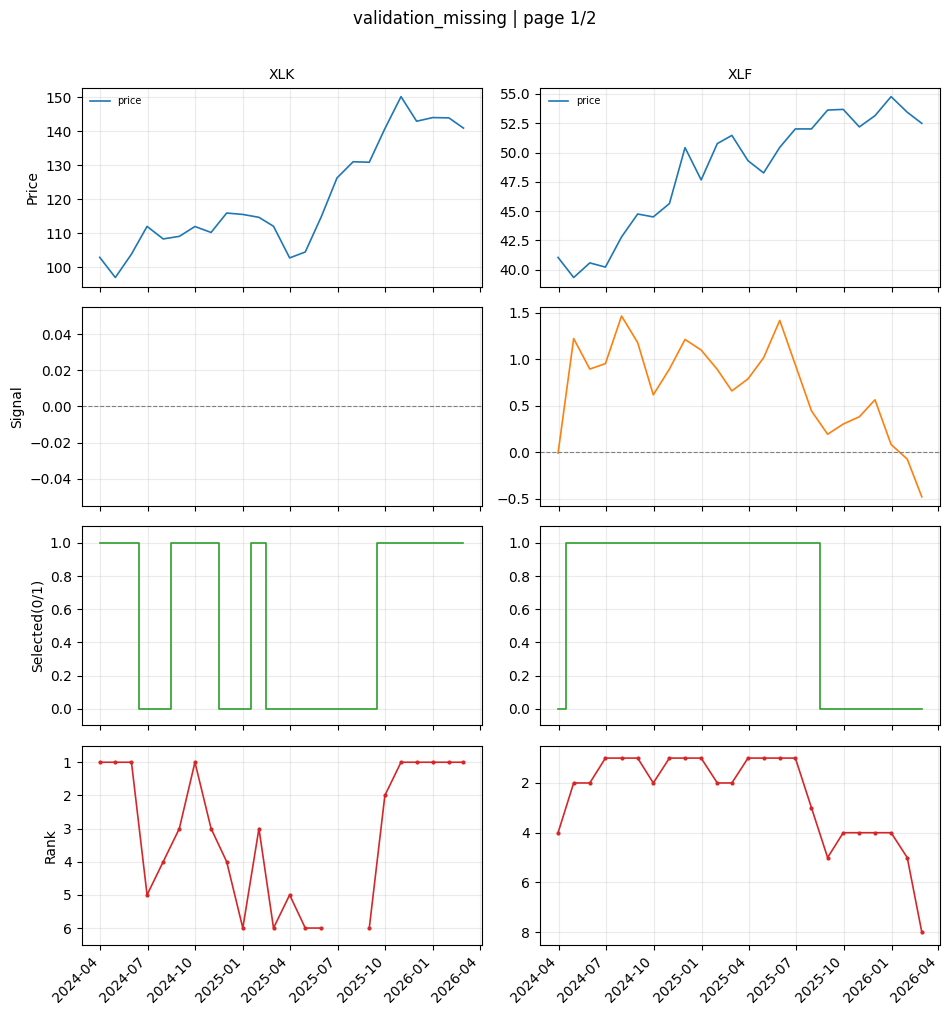

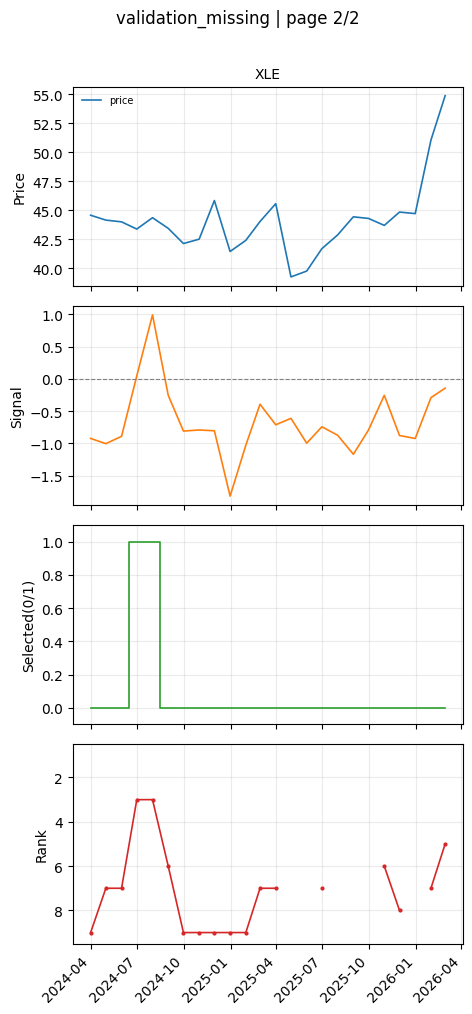

OK: missing-data visualization works
OK: full-ticker visualization is not empty (pages= 3 )


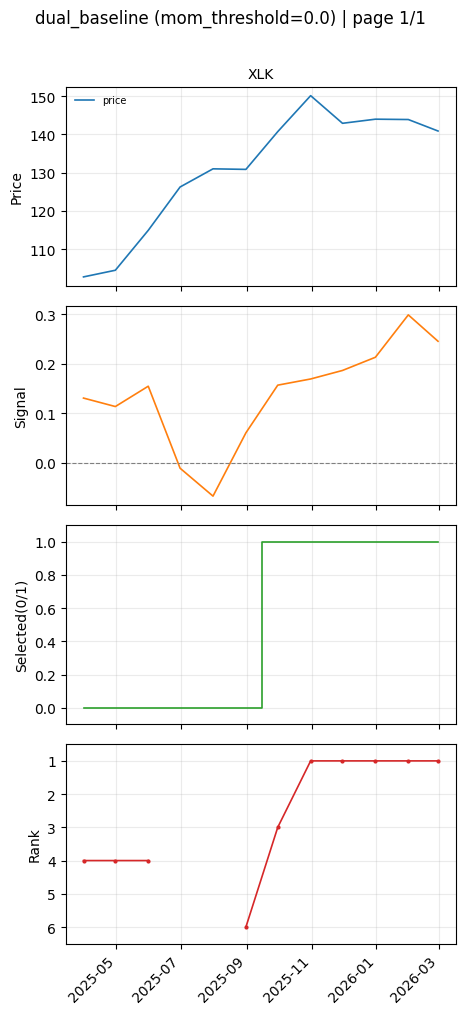

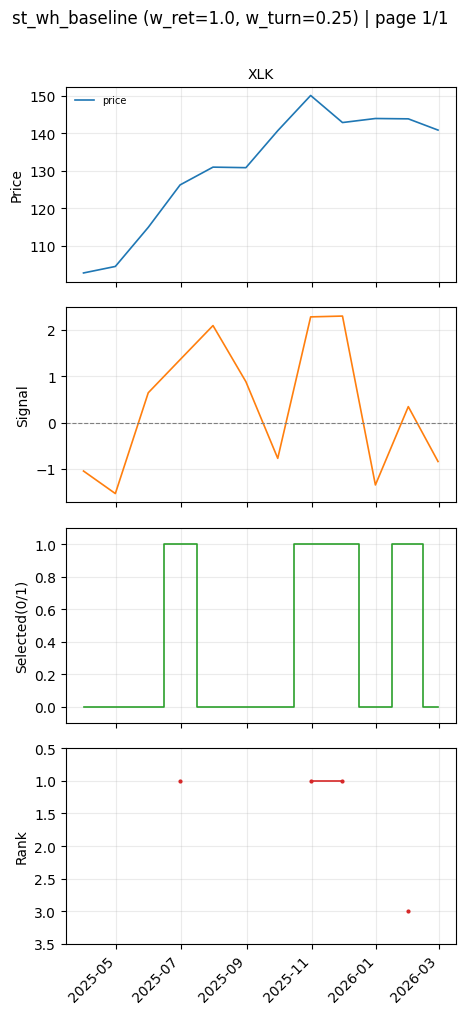

OK: run_signal_panel works for dual/st/user strategies


In [13]:

# -------------------------
# Validation / edge-case tests
# -------------------------
# 1) IF validation: wrong shape should fail
try:
    bad_df = pd.DataFrame({'A': [1, 2, 3]}, index=monthly_ret.index[:3])
    _validate_frame_shape(bad_df, context, 'bad_score')
    raise AssertionError('Expected validation error for wrong columns')
except ValueError:
    print('OK: wrong-column validation works')

# 2) constant score signal should still run (if eligibility gives enough assets)
def constant_score_fn(context: SignalContext, params: dict) -> pd.DataFrame:
    return pd.DataFrame(1.0, index=context.monthly_ret.index, columns=context.monthly_ret.columns)


def constant_elig_fn(context: SignalContext, params: dict) -> pd.DataFrame:
    return context.monthly_ret.notna()


const_spec = SignalSpec(
    name='constant_test_signal',
    description='boundary test',
    params_schema={},
    score_fn=constant_score_fn,
    eligibility_fn=constant_elig_fn,
)

const_res = run_backtest(const_spec, {}, context, selection_cfg, eval_cfg)
print('OK: constant signal run months =', len(const_res.summary))

# 3) top_k exceeds available eligible assets (should not crash)
wide_cfg = SelectionConfig(top_k=99, long_only=True, rebalance='monthly', cost_bps=DEFAULT_COST_BPS)
const_res2 = run_backtest(const_spec, {}, context, wide_cfg, eval_cfg)
print('OK: top_k > available handled; avg holdings =', float((const_res2.weights > 0).sum(axis=1).mean()))

# 4) high-NaN score should fail
try:
    nan_df = pd.DataFrame(np.nan, index=monthly_ret.index, columns=monthly_ret.columns)
    _validate_frame_shape(nan_df, context, 'nan_score')
    raise AssertionError('Expected NaN-ratio validation error')
except ValueError:
    print('OK: high-NaN validation works')

# 5) IF alignment for panel fields
assert panel_result.score_hold.index.equals(panel_result.eligibility_hold.index)
assert panel_result.score_hold.index.equals(panel_result.selected_hold.index)
assert panel_result.score_hold.index.equals(panel_result.rank_hold.index)
assert panel_result.score_hold.columns.equals(panel_result.eligibility_hold.columns)
assert panel_result.score_hold.columns.equals(panel_result.selected_hold.columns)
assert panel_result.score_hold.columns.equals(panel_result.rank_hold.columns)
print('OK: score/eligibility/selected/rank frame alignment works')

# 6) time alignment check: score_hold[h] must equal raw score[m]
spec_check = SIGNAL_REGISTRY[panel_signal_name]
score_raw, _ = build_signal_matrices(spec_check, panel_params, context)
h0 = panel_result.form_month_by_hold.index[0]
m0 = panel_result.form_month_by_hold.loc[h0]
score_h = panel_result.score_hold.loc[h0].reindex(score_raw.columns)
score_m = score_raw.loc[m0].reindex(score_raw.columns)
assert np.allclose(score_h.to_numpy(dtype=float), score_m.to_numpy(dtype=float), equal_nan=True)
print('OK: m->h time alignment works')

# 7) selected alignment
selected_from_weight = (panel_result.weights > 0).reindex(index=panel_result.selected_hold.index, columns=panel_result.selected_hold.columns).fillna(False)
assert panel_result.selected_hold.astype(bool).equals(selected_from_weight.astype(bool))
print('OK: selected_hold aligns with weights')

# 8) rank alignment
assert panel_result.rank_hold.where(~panel_result.eligibility_hold).isna().all().all()
valid_rank = panel_result.rank_hold.where(panel_result.eligibility_hold).stack()
assert len(valid_rank) > 0
assert float(valid_rank.min()) >= 1.0 - 1e-12
print('OK: rank validity works (ineligible->NaN, eligible>=1)')

# 9) tie boundary (all score tie -> rank=1 when tie_method=min)
const_valid = const_res.rank_hold.dropna(how='all')
const_row = const_valid.iloc[0].dropna()
assert const_row.nunique() == 1 and float(const_row.iloc[0]) == 1.0
print('OK: tie_method=min boundary works')

# 10) missing-data boundary in panel visualization
panel_cfg_small = PanelConfig(
    tickers=['XLK', 'XLF', 'XLE'],
    start=monthly_ret.index[-24],
    end=monthly_ret.index[-1],
    tickers_per_page=2,
    tie_method='min',
    normalize_price=False,
)
panel_small = build_asset_panel_frame(panel_result, context, panel_cfg_small)
panel_small_missing = panel_small.copy()
mask = panel_small_missing['ticker'] == panel_small_missing['ticker'].iloc[0]
panel_small_missing.loc[mask, 'signal'] = np.nan
figs_missing = plot_asset_quad_pages(panel_small_missing, panel_cfg_small, title_prefix='validation_missing')
assert len(figs_missing) > 0
for fig in figs_missing:
    plt.close(fig)
print('OK: missing-data visualization works')

# 11) visualization sanity for full-ticker mode
assert len(panel_figs) > 0
print('OK: full-ticker visualization is not empty (pages=', len(panel_figs), ')')

# 12) arbitrary strategy compatibility
panel_cfg_tiny = PanelConfig(
    tickers=['XLK'],
    start=monthly_ret.index[-12],
    end=monthly_ret.index[-1],
    tickers_per_page=1,
    tie_method='min',
    normalize_price=False,
)
strategy_tests = [
    ('dual_baseline', {'mom_threshold': 0.0}),
    ('st_wh_baseline', {'w_ret': 1.0, 'w_turn': 0.25}),
    ('user_mom_turn_blend', panel_params),
]
for sig_name, sig_params in strategy_tests:
    _, test_panel_df, test_figs = run_signal_panel(
        signal_name=sig_name,
        params=sig_params,
        context=context,
        selection_cfg=selection_cfg,
        eval_cfg=eval_cfg,
        panel_cfg=panel_cfg_tiny,
    )
    assert len(test_panel_df) > 0 and len(test_figs) > 0
    for fig in test_figs:
        plt.close(fig)
print('OK: run_signal_panel works for dual/st/user strategies')


In [14]:

# -------------------------
# Quick usage recap
# -------------------------
print('How to add your own signal:')
print('1) define score_fn(context, params) returning DataFrame(index=formation months, columns=tickers)')
print('2) optionally define eligibility_fn(context, params)')
print('3) register_signal(SignalSpec(...))')
print('4) run_backtest / evaluate_results / run_grid_search / run_random_search')
print('5) run_signal_panel(signal_name, params, ..., panel_cfg) for 4-row per-asset visualization')


How to add your own signal:
1) define score_fn(context, params) returning DataFrame(index=formation months, columns=tickers)
2) optionally define eligibility_fn(context, params)
3) register_signal(SignalSpec(...))
4) run_backtest / evaluate_results / run_grid_search / run_random_search
5) run_signal_panel(signal_name, params, ..., panel_cfg) for 4-row per-asset visualization
